In [55]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import sqlite3
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import os

### 결측치 처리 (결측치 보간법 6가지 앙상블)

In [94]:
# 데이터 읽기
train_df = pd.read_csv('data_train.csv')
submit_test_df = pd.read_csv('data_test.csv')

In [95]:
missing_train_data = [col for col in train_df.columns if train_df[col].isna().any()]
missing_test_data  = [col for col in submit_test_df.columns  if submit_test_df[col].isna().any()]

In [96]:
from scipy import interpolate
import pandas as pd

def ensemble_interpolation(df, missing_cols):
    df = df.copy().reset_index(drop=True)

    for col in missing_cols:
        series = df[col]
        total_len = len(series)

        lst_nan = series[series.isna()].index.tolist()
        lst_val = series[series.notna()].index.tolist()

        # 비결측값이 하나도 없으면 건너뛰기
        if len(lst_val) == 0:
            continue

        # 사용할 보간 기법 선택
        methods = ['previous', 'nearest', 'zero', 'slinear']
        if len(lst_val) >= 3:
            methods += ['quadratic', 'cubic']

        # 함수 만들기
        funcs = {}
        for kind in methods:
            funcs[kind] = interpolate.interp1d(
                lst_val, series[lst_val],
                kind=kind,
                fill_value="extrapolate",
                assume_sorted=True
            )

        # 예측값 생성
        df_interp = pd.DataFrame(
            {kind: func(lst_nan) for kind, func in funcs.items()},
            index=lst_nan
        )

        # mean 컬럼 생성
        df_interp['mean'] = df_interp.mean(axis=1)

        # 반영
        df.loc[df_interp.index, col] = df_interp['mean']

    return df

In [97]:
# 보간 함수 호출
train_df = ensemble_interpolation(train_df, missing_train_data)
submit_test_df  = ensemble_interpolation(submit_test_df, missing_test_data)

In [98]:
missing_data_1 = train_df.isnull().sum()
missing_data_1 = missing_data_1[missing_data_1 > 0]
print(missing_data_1)

missing_data_2 = submit_test_df.isnull().sum()
missing_data_2 = missing_data_2[missing_data_2 > 0]
print(missing_data_2)

Construction_PMI    204
Services_PMI        204
dtype: int64
Series([], dtype: int64)


결측치 밖에없는 칼럼은 삭제

In [61]:
train_df = train_df.drop(['Construction_PMI', 'Services_PMI'], axis=1)

# 모델링 함수 및 최적화 함수

In [62]:
### Optuna study 저장 설정
study_name = 'xgb_label_v1'
db_dir = os.path.join(os.getcwd(), 'optuna')
os.makedirs(db_dir, exist_ok=True)
storage_name = f'sqlite:///{os.path.abspath(os.path.join(db_dir, f"{study_name}.db"))}'

In [63]:
#타겟 분리 및 데이터 분할
target_df = train_df['Natural_Gas_US_Henry_Hub_Gas']
train_df = train_df.drop(columns=['date', 'Natural_Gas_US_Henry_Hub_Gas'])
train_df, test_df, target_df, test_target_df = train_test_split(train_df, target_df, test_size = 0.2)

In [64]:
# 모델별 objective 함수정의(XGBoost)
def objectiveLR_xgb(trial: Trial, train_df, target_df, test_df, test_target_df):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    'max_depth': trial.suggest_int('max_depth', 3, 30),
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
  }
  model = xgb.XGBRegressor(objective='reg:squarederror', **params)
  model.fit(train_df, target_df)
  predictions = model.predict(test_df)
  rmse = np.sqrt(mean_squared_error(test_target_df, predictions))
  return rmse

# 모델별 objective 함수 정의 (Random Forest)
def objectiveLR_rf(trial: Trial, train_df, target_df, test_df, test_target_df):
  from sklearn.ensemble import RandomForestRegressor
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    'max_depth': trial.suggest_int('max_depth', 3, 30),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    'max_features': trial.suggest_float('max_features', 0.1, 1.0)
  }
  model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
  model.fit(train_df, target_df)
  predictions = model.predict(test_df)
  rmse = np.sqrt(mean_squared_error(test_target_df, predictions))
  return rmse

# 모델별 objective 함수 정의 (CatBoost)
def objectiveLR_catboost(trial: Trial, train_df, target_df, test_df, test_target_df):
  from catboost import CatBoostRegressor
  params = {
    'iterations': trial.suggest_int('iterations', 100, 1000),
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
    'depth': trial.suggest_int('depth', 4, 15),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
    'border_count': trial.suggest_int('border_count', 32, 255),
    'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0)
  }
  model = CatBoostRegressor(**params, verbose=False, random_state=42)
  model.fit(train_df, target_df)
  predictions = model.predict(test_df)
  rmse = np.sqrt(mean_squared_error(test_target_df, predictions))
  return rmse

In [65]:
# optuna 모델최적화 함수 정의
def optimize_model(model_name, objective_func, train_df, target_df, test_df, test_target_df):
    study_name = f'{model_name}_v1'
    storage_name = f'sqlite:///optuna/{study_name}.db'
    try:
        study = optuna.create_study(
            storage = storage_name,
            direction='minimize',
            sampler = TPESampler(multivariate=True, n_startup_trials=50, seed=42)
        )
        print(f'{model_name}: create new study')
    except:
        study = optuna.load_study(study_name = study_name, storage = storage_name)
        print(f'{model_name}:load existing study')
    
    study.optimize(lambda trial:objective_func(trial, train_df, target_df, test_df, test_target_df), n_trials=50)
    return study

In [66]:
#최적화된 모델로 예측 수행 함수
def get_optimized_predictions(model_name, study, train_df, target_df, test_df):
    if model_name == 'xgb':
        model = xgb.XGBRegressor(objective='reg:squarederror', **study.best_params)
    elif model_name == 'rf':
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    else:
        from catboost import CatBoostRegressor
        model = CatBoostRegressor(**study.best_params, verbose=False, random_state=42)
        
    model.fit(train_df, target_df)
    return model.predict(test_df)

# 학습 및 예측 수행

In [ ]:
#모델 학습 및 최적화 
print("모델 최적화 시작")
study_xgb = optimize_model('xgb',objectiveLR_xgb, train_df, target_df, test_df, test_target_df)
study_rf = optimize_model('rf', objectiveLR_rf, train_df, target_df, test_df, test_target_df)
study_catboost = optimize_model('catboost', objectiveLR_catboost, train_df, target_df, test_df, test_target_df)

모델 최적화 시작


c:\Users\82106\anaconda3\lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-04-23 02:46:54,610] A new study created in RDB with name: no-name-4a36d678-29af-4770-af7f-51bcec05dd38


xgb: create new study


[I 2025-04-23 02:46:57,272] Trial 0 finished with value: 0.7993141754366683 and parameters: {'n_estimators': 406, 'max_depth': 29, 'learning_rate': 0.029106359131330698, 'min_child_weight': 5, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 2.9152036385288193e-08}. Best is trial 0 with value: 0.7993141754366683.
[I 2025-04-23 02:47:02,243] Trial 1 finished with value: 0.910577651573828 and parameters: {'n_estimators': 873, 'max_depth': 19, 'learning_rate': 0.02607024758370768, 'min_child_weight': 1, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'gamma': 4.997040685255803e-07}. Best is trial 0 with value: 0.7993141754366683.
[I 2025-04-23 02:47:03,144] Trial 2 finished with value: 1.6469354137593049 and parameters: {'n_estimators': 222, 'max_depth': 8, 'learning_rate': 0.0040596116104843075, 'min_child_weight': 4, 'subsample': 0.7727780074568463, 'colsample_bytree': 0.7164916560792167, 'gamma': 0.000784915956255507}. Best is tr

rf: create new study


[I 2025-04-23 02:48:50,617] Trial 0 finished with value: 1.1940686139149606 and parameters: {'n_estimators': 406, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.24041677639819287}. Best is trial 0 with value: 1.1940686139149606.
[I 2025-04-23 02:48:50,976] Trial 1 finished with value: 1.1307802970308067 and parameters: {'n_estimators': 198, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 0.737265320016441}. Best is trial 1 with value: 1.1307802970308067.
[I 2025-04-23 02:48:51,214] Trial 2 finished with value: 1.1560128620576506 and parameters: {'n_estimators': 69, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.26364247048639056}. Best is trial 1 with value: 1.1307802970308067.
[I 2025-04-23 02:48:51,588] Trial 3 finished with value: 1.1219128280178163 and parameters: {'n_estimators': 224, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 0.362106226178

catboost: create new study


[I 2025-04-23 02:50:45,865] Trial 0 finished with value: 1.483143769540276 and parameters: {'iterations': 437, 'learning_rate': 0.07969454818643935, 'depth': 12, 'l2_leaf_reg': 0.0024430162614261413, 'border_count': 66, 'bagging_temperature': 0.15599452033620265}. Best is trial 0 with value: 1.483143769540276.
[I 2025-04-23 02:50:52,906] Trial 1 finished with value: 1.4575447273173245 and parameters: {'iterations': 152, 'learning_rate': 0.05399484409787434, 'depth': 11, 'l2_leaf_reg': 0.023585940584142682, 'border_count': 36, 'bagging_temperature': 0.9699098521619943}. Best is trial 1 with value: 1.4575447273173245.
[I 2025-04-23 02:50:58,616] Trial 2 finished with value: 1.2186952843547827 and parameters: {'iterations': 850, 'learning_rate': 0.0026587543983272706, 'depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'border_count': 100, 'bagging_temperature': 0.5247564316322378}. Best is trial 2 with value: 1.2186952843547827.
[I 2025-04-23 02:51:53,877] Trial 3 finished with value: 1.5

In [68]:
# 예측수행
pred_xgb = get_optimized_predictions('xgb', study_xgb, train_df, target_df, test_df)
pred_rf = get_optimized_predictions('rf', study_rf, train_df, target_df, test_df)
pred_catboost = get_optimized_predictions('catboost', study_catboost, train_df, target_df, test_df)

# 앙상블 예측
ensemble_mean = (pred_xgb + pred_rf + pred_catboost) / 3
weights = [
    1 / study_xgb.best_value,
    1 / study_rf.best_value,
    1 / study_catboost.best_value
]
weights = np.array(weights) / sum(weights)
ensemble_weighted = weights[0] * pred_xgb + weights[1] * pred_rf + weights[2] * pred_catboost

                Model    MAPE      R2
0             XGBoost  0.0733  0.9442
1        RandomForest  0.0831  0.8806
2            CatBoost  0.0719  0.9146
3      Ensemble(Mean)  0.0726  0.9221
4  Ensemble(Weighted)  0.0723  0.9261


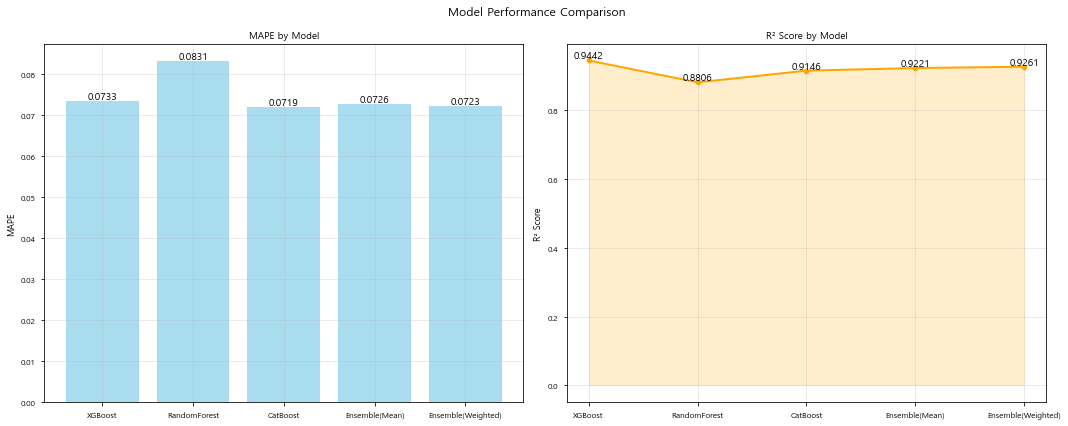

In [71]:
#모델 평가 결과 출력
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape

result = {
    'Model': ['XGBoost', 'RandomForest', 'CatBoost', 'Ensemble(Mean)', 'Ensemble(Weighted)'],
    'MAPE' : [
        mape(test_target_df, pred_xgb),
        mape(test_target_df, pred_rf),
        mape(test_target_df, pred_catboost),
        mape(test_target_df, ensemble_mean),
        mape(test_target_df, ensemble_weighted)
    ],
    'R2' : [
        r2_score(test_target_df, pred_xgb),
        r2_score(test_target_df, pred_rf),
        r2_score(test_target_df, pred_catboost),
        r2_score(test_target_df, ensemble_mean),
        r2_score(test_target_df, ensemble_weighted)
    ]
}
results_df = pd.DataFrame(result)
print(results_df.round(4))

#결과 시각화
import seaborn as sns
plt.style.use('seaborn-paper')
sns.set_palette("husl")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
models = results_df['Model'].tolist()
rmse_values = results_df['MAPE'].values
r2_values = results_df['R2'].values
bars = ax1.bar(models, rmse_values, color='skyblue', alpha=0.7)
ax1.set_title('MAPE by Model')
ax1.set_ylabel('MAPE')
ax1.grid(True, alpha=0.3)

for bar in bars:
  ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.4f}', ha='center', va='bottom')
ax2.plot(models, r2_values, marker='o', linewidth=2, color='orange')
ax2.fill_between(models, r2_values, alpha=0.2, color='orange')
ax2.set_title('R² Score by Model')
ax2.set_ylabel('R² Score')
ax2.grid(True, alpha=0.3)

for i, r2 in enumerate(r2_values):
  ax2.text(i, r2, f'{r2:.4f}', ha='center', va='bottom')
plt.suptitle('Model Performance Comparison')
plt.tight_layout()
plt.show()

# 테스트 데이터 추론

In [131]:
submit_test_df = pd.read_csv('data_test.csv')

missing_test_data  = [col for col in submit_test_df.columns  if submit_test_df[col].isna().any()]
submit_test_df  = ensemble_interpolation(submit_test_df, missing_test_data)

missing_data_2 = submit_test_df.isnull().sum()
missing_data_2 = missing_data_2[missing_data_2 > 0]
print(missing_data_2)

submit_test_df = submit_test_df.drop(['date', 'Services_PMI', 'Construction_PMI','Natural_Gas_US_Henry_Hub_Gas'], axis=1)

Series([], dtype: int64)


In [133]:
# 각 모델로 submit_test_df 예측
pred_submit_xgb = get_optimized_predictions('xgb', study_xgb, train_df, target_df, submit_test_df)
pred_submit_rf = get_optimized_predictions('rf', study_rf, train_df, target_df, submit_test_df)
pred_submit_catboost = get_optimized_predictions('catboost', study_catboost, train_df, target_df, submit_test_df)

# 가중치 계산
weights = [
    1 / study_xgb.best_value,  # XGBoost의 RMSE 역수
    1 / study_rf.best_value,   # RandomForest의 RMSE 역수
    1 / study_catboost.best_value  # CatBoost의 RMSE 역수
]
weights = np.array(weights) / sum(weights)  # 가중치 정규화

# 가중치 기반 앙상블
ensemble_weighted_submit = (
    weights[0] * pred_submit_xgb +
    weights[1] * pred_submit_rf +
    weights[2] * pred_submit_catboost
)

y_pred = ensemble_weighted_submit

# 제출 파일

In [ ]:
submission_df = pd.read_csv("submission_example.csv")
L = len(y_pred)
usable_len  = L - 3 

submission_df = submission_df.iloc[:usable_len].copy()  

submission_df["pred_1"] = y_pred[1 : usable_len + 1]    
submission_df["pred_2"] = y_pred[2 : usable_len + 2]    
submission_df["pred_3"] = y_pred[3 : usable_len + 3]    

# 3) 필요하면 인덱스 정리
submission_df = submission_df.reset_index(drop=True)

In [149]:
submission_df.to_csv("submission.csv", index=False)